<a href="https://colab.research.google.com/github/Levy95/Progetto-Corso-Reti-Neurali/blob/main/Progetto_Corso_Reti_Neurali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Device: serve per ottimizzare la computazione di calcoli sulle matrici
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Dataset: MNIST.
train_dataset_mnist = torchvision.datasets.MNIST(root='./data',
                                           train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data',
                                                train = False,
                                                transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Segue un'immagine estratta dal training-set del datset MNIST.

Label: 5


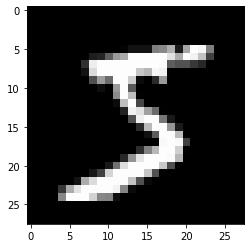

In [5]:
image, label = train_dataset_mnist[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [6]:
# Dataset: FashionMNIST
train_dataset_fashionmnist = torchvision.datasets.FashionMNIST(root = './data',
                                                               train = True,
                                                               transform = transforms.ToTensor(),
                                                               download = True)
test_dataset_fashionmnist = torchvision.datasets.FashionMNIST(root='./data',
                                                              train = True,
                                                              transform = transforms.ToTensor())                          

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Segue un'immagine estratta dal training-set del datset FashionMNIST.

Label: 9


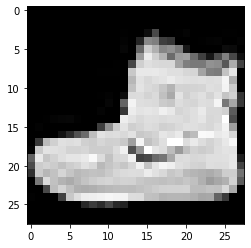

In [7]:
image, label = train_dataset_fashionmnist[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [8]:
# Dataset: CIFAR10
train_dataset_cifar10 = torchvision.datasets.CIFAR10(root = './data',
                                                      train = True,
                                                      transform = transforms.ToTensor(),
                                                      download = True)
test_dataset_cifar10 = torchvision.datasets.CIFAR10(root = './data',
                                                    train = False,
                                                    transform = transforms.ToTensor())                                                                                                   

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Segue un'immagine estratta dal training-set del datset CIFAR10.

Label: 6


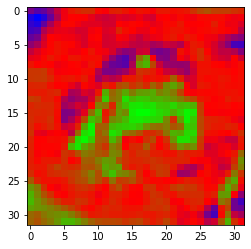

In [9]:
image, label = train_dataset_cifar10[0]
plt.imshow(image[0], cmap='brg')
print('Label:', label)

Seguono, nell'ordine, le classi che rappresentano l'implementazione della struttura della rete Feed-Forward con uno e due layer intermedi.

In [12]:
# Rete Neurale Feed-Forward completamente connessa con un solo layer: Shallow Network
class ReteNeurale1(nn.Module):
  def __init__(self,input_size, hidden_size, num_classi, act_func=1):
   super(ReteNeurale1, self).__init__()
   self.input_size = input_size
   self.l1 = nn.Linear(input_size, hidden_size)
   self.l2 = nn.Linear(hidden_size, num_classi)
   if act_func == 1:
    self.actfunc = nn.ReLU()
   elif act_func == 2:
    self.actfunc = nn.LeakyReLU()
   

  def forward(self, x):
     out = self.l1(x)
     out = self.actfunc(out)
     out = self.l2(out)
     return out

In [11]:
# Rete Neurale Feed-Forward completamente connessa con due layer
class ReteNeurale2(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, num_classi, act_func=1):
    super(ReteNeurale2, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size1)
    self.l2 = nn.Linear(hidden_size1, hidden_size2)
    self.l3 = nn.Linear(hidden_size2, num_classi)
    if act_func == 1:
      self.actfunc = nn.ReLU()
    elif act_func == 2:
      self.actfunc = nn.LeakyReLU()
  
  def forward(self, x):
    out = self.l1(x)
    out = self.actfunc(out)
    out = self.l2(out)
    out = self.actfunc(out)
    out = self.l3(out)
    return out

In [14]:
# Funzione che implementa il training di una rete neurale che compie classificazione di immagini.

def train_function(rete, load_tr_ds, opt, loss_fun, img_size, num_ep):
  # Inputs:
  # rete: istanza di una classe di rete neurale
  # load_tr_ds: training (loader) set del dataset prescelto
  # opt: algoritmo di learning
  # img_size: dimensione delle immagini
  # num_ep: numero di epoche di training
  # Output: loss
  n_tot_steps = len(load_tr_ds) # step = len(load_tr_ds)/batch_size
  loss_vec = [] # vettore in cui si salvano i valori della loss ad ogni step, serve per il plot
  for epoch in range(num_ep):
    for i, (immagini, etichette) in enumerate(load_tr_ds):
      # si coverte il formato dei dati
      immagini = immagini.reshape(-1, img_size).to(device)
      etichette = etichette.to(device)

      # Forward step: si passano i dati attraverso i layer
      outputs = rete(immagini)
      # Si calcola la loss
      loss = loss_fun(outputs, etichette)
      
      # Training step: si calcola il gradiente della loss e si compie un passo 
      # dell'algoritnmo di training
      opt.zero_grad()
      loss.backward()
      opt.step()
       
      # si stampano i valori della loss 
      if (i+1)%100 == 0:
        print (f'Epoch [{epoch+1}/{num_ep}], Step [{i+1}/{n_tot_steps}], Loss: {loss.item():.4f}') 
        loss_vec.append(loss.item()) # salvataggio dei valori della loss ad ogni step
        
  return loss_vec

In [15]:
# Funzione che testa una rete neurale neurale allenata per fare classificazione di immagini

def test_function(rete, load_ts_ds, img_size):
  # Input:
  # rete: istanza di una classe di rete neurale
  # lead_ts_ds: test (loader) set del dataset prescelto
  # img_size: dimensione delle immagini
  with torch.no_grad():
    num_corrette = 0
    num_campioni = 0
    for immagini, etichette in load_ts_ds:
      immagini = immagini.reshape(-1, img_size).to(device)
      etichette = etichette.to(device)
      output = rete(immagini)

      # max ha come output una tupla del tipo (valore, indice)
      _, pred = torch.max(output.data, 1)
      num_campioni += etichette.size(0)
      num_corrette += (pred == etichette).sum().item()

    # accuratezza della rete: percentuali di immagini etichettate correttamente sul campione di dati
    acc = 100 * num_corrette/num_campioni
    print(f'Accuracy della rete su 10000 immagini test: {acc} %')
    return acc

In [16]:
# Iperparametri
input_sizeA = 784 # per immagini 28x28 in scale di grigio
input_sizeB = 3072 # per immagini 32x32 in scale RGB
img_sizeA = 784
img_sizeB = 3072
hidden_size1 = 1000
hidden_size2 = 500
num_classi = 10
learning_rate = 0.01
batch_size = 100

# Si creano i data-loaders: servono per caricare i dati in batches di dimensioni prestabilite
train_loader_mnist = torch.utils.data.DataLoader(dataset=train_dataset_mnist,
                                           batch_size=batch_size,
                                           shuffle = True)
test_loader_mnist = torch.utils.data.DataLoader(dataset= test_dataset_mnist,
                                          batch_size=batch_size,
                                          shuffle=False)

train_loader_fashionmnist = torch.utils.data.DataLoader(dataset = train_dataset_fashionmnist,
                                                        batch_size = batch_size,
                                                        shuffle=True)
test_loader_fashionmnist = torch.utils.data.DataLoader(dataset = test_dataset_fashionmnist,
                                                       batch_size = batch_size,
                                                       shuffle = False)

train_loader_cifar10 = torch.utils.data.DataLoader(dataset = train_dataset_cifar10,
                                                   batch_size = batch_size,
                                                   shuffle = True)
test_loader_cifar10 = torch.utils.data.DataLoader(dataset = test_dataset_cifar10,
                                                  batch_size = batch_size,
                                                  shuffle = False)

Testiamo la rete neurale con un solo layer intermedio sui dataset MNIST e FashionMNIST.

In [17]:
# Instanziare la rete neurale scegliendo quale funzione di attivazione si vuole usare
rete1 = ReteNeurale1(input_sizeA, hidden_size1, num_classi, act_func=2).to(device)

# Scegliere l'algoritmo di learning e la funzione di output e loss
alg = torch.optim.SGD(rete1.parameters(), lr = learning_rate)
F = nn.CrossEntropyLoss()

In [18]:
print('Dataset MNIST:\n')
l1 = train_function(rete1, train_loader_mnist, alg, F, img_sizeA, 2)
a1 = test_function(rete1, test_loader_mnist, img_sizeA) 
print('\n')

Dataset MNIST:

Epoch [1/2], Step [100/600], Loss: 1.9830
Epoch [1/2], Step [200/600], Loss: 1.6004
Epoch [1/2], Step [300/600], Loss: 1.3295
Epoch [1/2], Step [400/600], Loss: 0.8822
Epoch [1/2], Step [500/600], Loss: 0.9849
Epoch [1/2], Step [600/600], Loss: 0.7718
Epoch [2/2], Step [100/600], Loss: 0.6622
Epoch [2/2], Step [200/600], Loss: 0.5149
Epoch [2/2], Step [300/600], Loss: 0.5491
Epoch [2/2], Step [400/600], Loss: 0.6395
Epoch [2/2], Step [500/600], Loss: 0.6684
Epoch [2/2], Step [600/600], Loss: 0.6249
Accuracy della rete su 10000 immagini test: 88.44 %




Esempio di come si sono eseguiti i grafici relativi al variare della loss durante la fase di training.

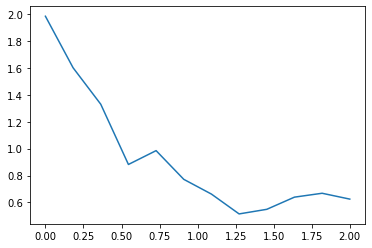

In [19]:
x = np.linspace(0, 2, 12)
y = l1
plt.plot(x,y)

In [20]:
print('Dataset FashionMNIST:\n')
l2 = train_function(rete1, train_loader_fashionmnist, alg, F, img_sizeA, 2)
a2 = test_function(rete1, test_loader_fashionmnist, img_sizeA)
print('\n')

Dataset FashionMNIST:

Epoch [1/2], Step [100/600], Loss: 1.3227
Epoch [1/2], Step [200/600], Loss: 1.0593
Epoch [1/2], Step [300/600], Loss: 0.8900
Epoch [1/2], Step [400/600], Loss: 0.7880
Epoch [1/2], Step [500/600], Loss: 0.7261
Epoch [1/2], Step [600/600], Loss: 0.9052
Epoch [2/2], Step [100/600], Loss: 0.6397
Epoch [2/2], Step [200/600], Loss: 0.6861
Epoch [2/2], Step [300/600], Loss: 0.6488
Epoch [2/2], Step [400/600], Loss: 0.5403
Epoch [2/2], Step [500/600], Loss: 0.5700
Epoch [2/2], Step [600/600], Loss: 0.6675
Accuracy della rete su 10000 immagini test: 79.42 %




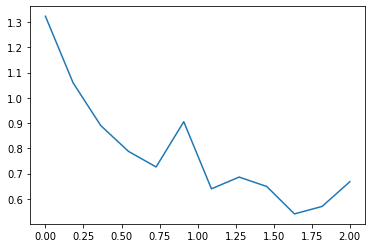

In [21]:
x = np.linspace(0, 2, 12)
y = l2
plt.plot(x,y)

Testiamo la rete neurale con un solo layer sul dataset CIFAR10. E' necessario creare una nuovo oggetto-rete poichè le dimensioni delle immagini di CIFAR10 sono diverse da quelle degli altri due dataset.

In [22]:
rete1B = ReteNeurale1(input_sizeB, hidden_size1, num_classi, act_func=1).to(device)
alg = torch.optim.Adam(rete1B.parameters(), lr = learning_rate)
print('Dataset CIFAR10:\n')
l3 = train_function(rete1B, train_loader_cifar10, alg, F, img_sizeB, 2)
a3 = test_function(rete1B, test_loader_cifar10, img_sizeB)

Dataset CIFAR10:

Epoch [1/2], Step [100/500], Loss: 2.1806
Epoch [1/2], Step [200/500], Loss: 2.1249
Epoch [1/2], Step [300/500], Loss: 1.9819
Epoch [1/2], Step [400/500], Loss: 1.9043
Epoch [1/2], Step [500/500], Loss: 1.8790
Epoch [2/2], Step [100/500], Loss: 1.8760
Epoch [2/2], Step [200/500], Loss: 1.9750
Epoch [2/2], Step [300/500], Loss: 1.9452
Epoch [2/2], Step [400/500], Loss: 2.0569
Epoch [2/2], Step [500/500], Loss: 2.0128
Accuracy della rete su 10000 immagini test: 24.05 %


In [ ]:
x = np.linspace(0, 2, 12)
y = l3
plt.plot(x,y)

Allo stesso modo ora testiamo la rete con due layer

In [23]:
rete2 = ReteNeurale2(input_sizeA, hidden_size1, hidden_size2, num_classi, act_func=1).to(device)
alg = torch.optim.Adam(rete2.parameters(), lr=learning_rate)

In [24]:
print('Dataset MNIST:\n')
l1b = train_function(rete2, train_loader_mnist, alg, F, img_sizeA, 2)
a1 = test_function(rete2, test_loader_mnist, img_sizeA)

Dataset MNIST:

Epoch [1/2], Step [100/600], Loss: 0.3254
Epoch [1/2], Step [200/600], Loss: 0.2640
Epoch [1/2], Step [300/600], Loss: 0.2918
Epoch [1/2], Step [400/600], Loss: 0.2688
Epoch [1/2], Step [500/600], Loss: 0.0744
Epoch [1/2], Step [600/600], Loss: 0.0934
Epoch [2/2], Step [100/600], Loss: 0.1003
Epoch [2/2], Step [200/600], Loss: 0.0890
Epoch [2/2], Step [300/600], Loss: 0.1298
Epoch [2/2], Step [400/600], Loss: 0.0168
Epoch [2/2], Step [500/600], Loss: 0.0804
Epoch [2/2], Step [600/600], Loss: 0.2289
Accuracy della rete su 10000 immagini test: 96.07 %


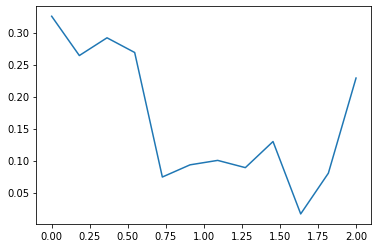

In [25]:
x = np.linspace(0, 2, 12)
y = l1b
plt.plot(x,y)

In [27]:
print('Dataset FashionMNIST:\n')
l2b = train_function(rete2, train_loader_fashionmnist, alg, F, img_sizeA, 2)
a2 = test_function(rete2, test_loader_fashionmnist, img_sizeA)

Dataset FashionMNIST:

Epoch [1/2], Step [100/600], Loss: 0.5123
Epoch [1/2], Step [200/600], Loss: 0.4538
Epoch [1/2], Step [300/600], Loss: 0.4965
Epoch [1/2], Step [400/600], Loss: 0.3489
Epoch [1/2], Step [500/600], Loss: 0.5636
Epoch [1/2], Step [600/600], Loss: 0.3912
Epoch [2/2], Step [100/600], Loss: 0.4816
Epoch [2/2], Step [200/600], Loss: 0.4623
Epoch [2/2], Step [300/600], Loss: 0.5094
Epoch [2/2], Step [400/600], Loss: 0.4405
Epoch [2/2], Step [500/600], Loss: 0.4251
Epoch [2/2], Step [600/600], Loss: 0.4260
Accuracy della rete su 10000 immagini test: 86.10666666666667 %


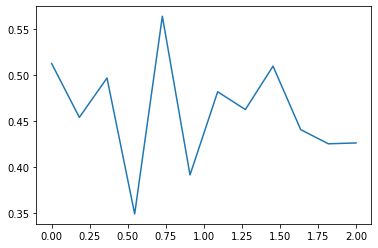

In [28]:
x = np.linspace(0, 2, 12)
y = l2b
plt.plot(x,y)

In [29]:
rete2B = ReteNeurale2(input_sizeB, hidden_size1, hidden_size2, num_classi, act_func=1).to(device)
alg = torch.optim.SGD(rete2B.parameters(), lr = learning_rate)
print('Dataset CIFAR10:\n')
l3b = train_function(rete2B, train_loader_cifar10, alg, F, img_sizeB, 2)
a3 = test_function(rete2B, test_loader_cifar10, img_sizeB)

Dataset CIFAR10:

Epoch [1/2], Step [100/500], Loss: 2.2514
Epoch [1/2], Step [200/500], Loss: 2.1721
Epoch [1/2], Step [300/500], Loss: 2.0981
Epoch [1/2], Step [400/500], Loss: 2.0639
Epoch [1/2], Step [500/500], Loss: 1.9865
Epoch [2/2], Step [100/500], Loss: 1.9710
Epoch [2/2], Step [200/500], Loss: 1.8909
Epoch [2/2], Step [300/500], Loss: 1.9929
Epoch [2/2], Step [400/500], Loss: 1.9474
Epoch [2/2], Step [500/500], Loss: 2.0664
Accuracy della rete su 10000 immagini test: 32.35 %


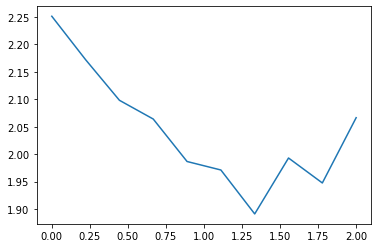

In [32]:
x = np.linspace(0, 2, 10)
y = l3b
plt.plot(x,y)